## FAKE NEWS DETECTOR - LSTM

### Imports

In [1]:
! pip3 install keras
! pip3 install scikit-learn
! pip3 install Keras-Preprocessing
! pip3 install nltk

#### Others
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sys
import os
from collections import defaultdict
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

#### Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 730.4 kB/s eta 0:00:00


### Constants

In [2]:
DATA_BASE_PATH = "./"
GLOVE_DIR = "./"

TRAIN_RATIO = 0.70
TEST_RATIO = 0.30
MAX_FEATURES_VECTORIZER= 500
TRAINING_EPOCHS = 20 # Number of training epochs
BATCH_SIZE = 128

VOCABULARY_SIZE = 200000 # the size of the vocabulary, indicating the maximum number of unique words that will be considered during the text embedding process.
SENTENCE_LENGTH = 1000 # the desired length of each sentence or text sequence after preprocessing. It indicates the number of words that will be included in each sequence.
EMBEDDING_VECTOR_FEATURES = 100 # the number of dimensions in which each word will be represented in the embedding space. It determines the size of the word vectors generated, where words are mapped to continuous vector representations for machine learning tasks.

### Load data

In [3]:
# Load Dataset
train_data = pd.read_csv(DATA_BASE_PATH + 'train_test_mix.csv')

### Preprocessing

The provided code snippet involves data preprocessing steps.

First of all, we must remove the rows with missing values (NaN) from the train_data dataset.

After dropping rows, the indices of the remaining rows may become non-contiguous by resetting the index of the DataFrame to ensure continuous and sequential indexing. This results in an updated DataFrame with a reset index, where the previous index values are moved to a new column, and a new sequential index is assigned to each row.

In [4]:
# Remove NaN
train_data = train_data.dropna()
train_data.reset_index(inplace = True)

train_data.loc[train_data.label == 'REAL', 'label'] = 0
train_data.loc[train_data.label == 'FAKE', 'label'] = 1

First step to continue preprocessing is to prepare input features and targe labels by creating two dataframes, one of them leaving only the input features for model training, and the other with the 'label' column is assigned to the variable y_train, representing the target labels corresponding to the input features in x_train.

In [5]:
train_data['title_text'] = train_data[["title", "text"]].apply("".join, axis=1)

The provided code snippet initializes a PorterStemmer (from the Natural Language Toolkit (NLTK) library is initialized. The stemmer will be used to reduce words to their root form.) for text stemming and creates empty lists corpus and words. It iterates through each title in the DataFrame, removing non-alphanumeric characters, converting to lowercase, and splitting into words. The words are then stemmed and stopwords are removed, resulting in preprocessed sentences added to the corpus list and individual stemmed words to the words list. This process prepares the text data for analysis or model training.

In [6]:
# Sample text cleaning functions
def clean_text(text):
    # Remove HTML tags
    cleaned_text = re.sub(r'<.*?>', '', text)

    # Remove special characters and punctuations except for periods and exclamation marks
    cleaned_text = re.sub(r'[^\w\s.!?]', '', cleaned_text)

    # Remove extra whitespaces and newlines
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip()

    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

# Applying text cleaning and preprocessing to 'text' column
train_data['title_text'] = train_data['title_text'].apply(clean_text)

In [7]:
print(train_data[0:5])

   index         idd                                              title  \
0      0  Fq+C96tcx+  ‘A target on Roe v. Wade ’: Oklahoma bill maki...   
1      1  bHUqK!pgmv  Study: women had to drive 4 times farther afte...   
2      2  4Y4Ubf%aTi        Trump, Clinton clash in dueling DC speeches   
3      3  _CoY89SJ@K  Grand jury in Texas indicts activists behind P...   
4      4  +rJHoRQVLe  As Reproductive Rights Hang In The Balance, De...   

                                                text label  \
0  UPDATE: Gov. Fallin vetoed the bill on Friday....     0   
1  Ever since Texas laws closed about half of the...     0   
2  Donald Trump and Hillary Clinton, now at the s...     0   
3  A Houston grand jury investigating criminal al...     0   
4  WASHINGTON -- Forty-three years after the Supr...     0   

                                          title_text  
0  a target on roe v. wade oklahoma bill making i...  
1  study women had to drive 4 times farther after...  
2  trump cl

In the provided code, a copy of the training data x_train is assigned to the variable messages. The reset_index() method is then applied to the messages DataFrame. This method is often used to reset the index of a DataFrame, which means that the current index (usually numeric) is replaced with a default integer index starting from 0.

By calling reset_index() with the inplace=True parameter, the operation modifies the DataFrame messages in place, without creating a new DataFrame. This can be useful when you want to apply changes directly to the existing DataFrame instead of creating a new copy.

It's important to note that the specific impact of resetting the index depends on the structure and context of your data. In some cases, you might need to reset the index to make further manipulations or analyses easier, especially if the original index is not providing meaningful information. However, it's recommended to understand the implications of changing the index before applying it to your data.

In [8]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(train_data['title_text'].tolist())
sequences = tokenizer.texts_to_sequences(train_data['title_text'].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 76613 unique tokens.


One-hot encoding is often used as a preprocessing step when working with natural language processing (NLP) tasks like text classification, including the detection of fake news using techniques like LSTM (Long Short-Term Memory) networks. LSTM networks are a type of recurrent neural network (RNN) that can effectively model sequences and patterns in sequential data like text.

One-hot encoding is used with LSTM for the following reasons:

- Input Representation: LSTM networks require input data to be in a numerical format. One-hot encoding converts words into numerical vectors, where each word is represented by a vector with all zeros except for a single "1" at the index corresponding to the word's position in the vocabulary. This allows text data to be fed into the network as numeric sequences.

- Sparse Data Handling: NLP datasets typically have a large vocabulary, resulting in sparse data when using raw text representation. One-hot encoding reduces this sparsity by representing each word as a fixed-size vector. This can make training more efficient and reduce memory requirements.

- Word Relationships: One-hot encoding treats each word as independent, which may not capture the semantic relationships between words. However, LSTM networks can learn contextual information from sequences of one-hot encoded vectors, allowing them to capture word relationships and dependencies within a text.

- Sequence Modeling: LSTM networks excel at modeling sequences, and one-hot encoded vectors provide a suitable input format for sequential data. LSTM cells can maintain and update internal states that help capture longer-range dependencies in text.

- Embedding Layer: In many cases, one-hot encoded vectors are further transformed using an embedding layer within the LSTM network. This layer learns dense representations (word embeddings) that capture semantic relationships between words. These learned embeddings can enhance the model's ability to understand the meaning and context of words.

In the context of detecting fake news, one-hot encoding followed by LSTM modeling allows the network to learn patterns and relationships within the textual data, enabling the model to identify relevant features and make accurate predictions about the authenticity of news articles.

In the following lines, after encoding (0, 1) the words in the given corpus, the variable embedded_docs is created using the pad_sequences function from Keras. This step is essential when preparing text data for training neural network models like LSTM for natural language processing tasks.

The onehot_repr list contains one-hot encoded representations of words in news article texts, and each inner list corresponds to a sequence. The padding='post' parameter ensures that padding is added to the end of each sequence, and maxlen specifies the desired sequence length after padding. The resulting embedded_docs array contains the transformed and padded sequences, forming the input data for the LSTM model.

This preparation process is vital to maintain consistent sequence lengths required for neural network training and allows the data to be effectively fed into the LSTM model for further analysis and prediction.

In [9]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=SENTENCE_LENGTH)
labels = to_categorical(np.asarray(train_data['label'].tolist()),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (4593, 1000)
Shape of label tensor: (4593, 2)


In the provided code and output, the array embedded_docs[0] represents the first sequence of word indices after one-hot encoding and padding. Each number in the array corresponds to the index of a word in the vocabulary, and this sequence has been padded with zeros to match a specified length (maxlen). This format is suitable for input into neural network models, such as LSTM, where each number indicates the word's presence in the text. The zeros represent the padding introduced to ensure uniform sequence lengths across all input samples. This processed array serves as a structured input for the subsequent stages of the LSTM model, enabling the analysis and prediction of the underlying patterns in the text data.

In [10]:
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
data = data[indexes]
labels = labels[indexes]

In [11]:
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=TEST_RATIO, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 3215 689 689
real & fake news in train,valt,test:
[1606. 1609.]
[348. 341.]
[342. 347.]


In [12]:
# Using Pre-trained word embeddings
embeddings_index = {}
f = open((GLOVE_DIR + 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_VECTOR_FEATURES))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_VECTOR_FEATURES,
                            weights=[embedding_matrix],
                            input_length=SENTENCE_LENGTH)

Total 400000 word vectors in Glove.


### Neural Network Design

As an option of design, the goal is to create a sequential neural network model for text classification, where the input text sequences are transformed through an embedding layer, passed through an LSTM layer to capture sequence information, and finally output a binary classification prediction. Dropout layers are used to mitigate overfitting during training.

The chosen architecture employs a Convolutional Neural Network (CNN) for fake news detection due to its effective feature extraction capabilities from textual data. Each layer in this architecture serves a specific purpose in capturing distinctive linguistic patterns that differentiate between authentic and fabricated news articles.

- Input Layer (sequence_input): The input layer sets the foundation by defining the shape of input data. In this case, the shape corresponds to the length of the input sentences, which ensures that the network can handle variable-length text inputs.

- Embedding Layer (embedded_sequences): The embedding layer transforms the discrete tokens of each input sentence into dense vector representations. These vectors encode semantic relationships between words, enabling the network to understand the contextual meanings of words within sentences. This embedding process captures linguistic nuances that contribute to distinguishing fake news from real news.

- Convolutional and Pooling Layers (l_cov1, l_pool1, l_cov2, l_pool2, l_cov3, l_pool3): The architecture employs a series of convolutional and pooling layers to extract hierarchical features from the embedded sequences. Convolutional layers employ filters that slide across the embedded data, detecting local patterns and features. Subsequent max-pooling layers downsample the outputs, focusing on the most important information. The layers are designed to recognize features at varying scales and gradually capture more complex linguistic structures.

- Flatten Layer (l_flat): The flattened layer transforms the pooled outputs into a one-dimensional vector. This vectorized representation retains the learned features and facilitates their processing in subsequent layers.

- Dense Layer (l_dense): A fully connected dense layer follows the flattened representation. This layer learns higher-level abstractions from the features extracted in earlier layers. The activation function, in this case, ReLU (Rectified Linear Activation), introduces non-linearity to the network, enabling it to capture complex relationships in the data.

- Output Layer (preds): The output layer employs the softmax activation function to produce class probabilities for the two categories: fake news and real news. The network's final predictions are based on these probabilities.

The architecture's sequence of convolutional, pooling, and dense layers enables it to detect complex patterns in textual data. The CNN's ability to automatically learn relevant features from the input text makes it well-suited for distinguishing between credible and dubious news content. The model's parameters are optimized using the categorical cross-entropy loss function during training, with the Adadelta optimizer. The final evaluation metric, accuracy, gauges the model's performance in correctly classifying fake and real news articles. Overall, this CNN architecture offers a robust framework for fake news detection by effectively capturing and interpreting textual patterns.


In [13]:
# Simple CNN model
sequence_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

simple_cnn = Model(sequence_input, preds)
simple_cnn.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
print(simple_cnn.summary())

Fitting the simple convolutional neural network model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         7661400   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)   

The provided architecture outlines a Complex Convolutional Neural Network (CNN) tailored for the detection of fake news. This network structure is designed to effectively process and classify textual data by leveraging the hierarchical feature extraction capabilities of convolutional layers. Each layer within the network serves a distinct role in feature extraction and information processing.

- Input Layer: The input layer of the network is designed to accept sequences of integers, each representing a word or token within a news article. These sequences are expected to have a fixed length of 1000 tokens, providing a consistent format for the input data.

- Embedding Layer: The embedding layer plays a crucial role in translating the discrete token sequences into continuous, dense vectors. These vectors capture semantic relationships between words and their contextual meanings. This layer's output serves as a foundation for subsequent layers, allowing the network to process the textual content effectively.

- Convolutional and Pooling Layers: The architecture includes a series of convolutional layers, each applied with different filter sizes. These filters slide over the embedded sequences to capture local patterns and features. The convolutional layers are followed by max-pooling layers, which downsample the outputs by selecting the maximum value from each window. This combination of convolution and pooling allows the network to capture features at various scales, recognizing both short and long-range dependencies within the text.

- Concatenation Layer: The outputs of the convolutional layers are concatenated along a specific axis, resulting in a merged representation. This merging of features from different filter sizes enhances the network's ability to capture diverse linguistic patterns and characteristics within the text.

- Convolutional and Pooling Layers (Further Refinement): Additional convolutional and pooling layers are applied to the merged feature representation. These layers serve to further refine the learned features and reduce the spatial dimensions of the data.

- Flatten Layer: The flattened layer transforms the pooled output into a one-dimensional vector. This vector retains the learned features in a structured format that can be easily processed by subsequent dense layers.

- Dense Layers: A series of fully connected dense layers follow the flattened representation. These dense layers allow the network to learn complex relationships between the extracted features, enabling higher-level abstractions to be captured.

- Output Layer: The final dense layer employs a softmax activation function to generate class probabilities for the two possible categories: fake news and not fake news. The model's output indicates the likelihood that a given news article falls into each class.

- Model Compilation: The constructed network is compiled with the categorical cross-entropy loss function, which measures the difference between predicted and actual classes. The Adadelta optimizer is employed for updating model weights during training, and accuracy is used as the evaluation metric to assess the model's performance.

In essence, the architecture of the Complex CNN harnesses the power of convolutional layers to process textual data, capturing features and patterns that distinguish between credible and dubious news articles. By progressively refining these features through convolution, pooling, and dense layers, the network learns to make accurate predictions about the authenticity of news content. The careful arrangement of layers enables the model to effectively handle the complex and nuanced nature of textual data.

In [14]:
# Complex Convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(128, fsz, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)

l_merge = Concatenate()(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

complex_cnn = Model(sequence_input, preds)
complex_cnn.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
print(complex_cnn.summary())

Fitting a more complex convolutional neural network model
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 100)    7661400     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 998, 128)     38528       ['embedding[1][0]']              
                                                                                                  
 conv1d_4 (Conv1D)              (None, 997, 128)     51328       ['embedding[1][0]']              
                                  

### Tranining

In [15]:
# Model trained with Tensorflow
history = simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
26/26 [==============================] - 59s 2s/step - loss: 0.6850 - acc: 0.5431 - val_loss: 0.6804 - val_acc: 0.5689
Epoch 2/20
26/26 [==============================] - 55s 2s/step - loss: 0.6806 - acc: 0.5692 - val_loss: 0.6770 - val_acc: 0.5820
Epoch 3/20
26/26 [==============================] - 54s 2s/step - loss: 0.6773 - acc: 0.5876 - val_loss: 0.6742 - val_acc: 0.6038
Epoch 4/20
26/26 [==============================] - 55s 2s/step - loss: 0.6744 - acc: 0.6149 - val_loss: 0.6719 - val_acc: 0.6067
Epoch 5/20
26/26 [==============================] - 56s 2s/step - loss: 0.6720 - acc: 0.6240 - val_loss: 0.6697 - val_acc: 0.6139
Epoch 6/20
26/26 [==============================] - 53s 2s/step - loss: 0.6697 - acc: 0.6361 - val_loss: 0.6676 - val_acc: 0.6357
Epoch 7/20
26/26 [==============================] - 54s 2s/step - loss: 0.6675 - acc: 0.6429 - val_loss: 0.6656 - val_acc: 0.6313
Epoch 8/20
26/26 [==============================] - 54s 2s/step - loss: 0.6656 - acc: 0.64

In [16]:
history2 = complex_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
26/26 [==============================] - 125s 5s/step - loss: 0.7160 - acc: 0.4995 - val_loss: 0.6938 - val_acc: 0.5065
Epoch 2/20
26/26 [==============================] - 132s 5s/step - loss: 0.6877 - acc: 0.5176 - val_loss: 0.6777 - val_acc: 0.5312
Epoch 3/20
26/26 [==============================] - 131s 5s/step - loss: 0.6745 - acc: 0.5583 - val_loss: 0.6699 - val_acc: 0.5646
Epoch 4/20
26/26 [==============================] - 125s 5s/step - loss: 0.6671 - acc: 0.5888 - val_loss: 0.6641 - val_acc: 0.6096
Epoch 5/20
26/26 [==============================] - 124s 5s/step - loss: 0.6615 - acc: 0.6156 - val_loss: 0.6592 - val_acc: 0.6284
Epoch 6/20
26/26 [==============================] - 123s 5s/step - loss: 0.6571 - acc: 0.6271 - val_loss: 0.6549 - val_acc: 0.6705
Epoch 7/20
26/26 [==============================] - 123s 5s/step - loss: 0.6530 - acc: 0.6566 - val_loss: 0.6508 - val_acc: 0.6778
Epoch 8/20
26/26 [==============================] - 124s 5s/step - loss: 0.6492 - a

In [17]:
# Save the model to a file
simple_cnn.save('simple_cnn_model_fake_news.h5')
complex_cnn.save('complex_cnn_model_fake_news.h5')

### Testing

22/22 [==============================] - 4s 167ms/step
Correct predictions: 462.0
Total number of test examples: 689
Accuracy of model1:  0.6705370101596516
22/22 [==============================] - 2s 104ms/step


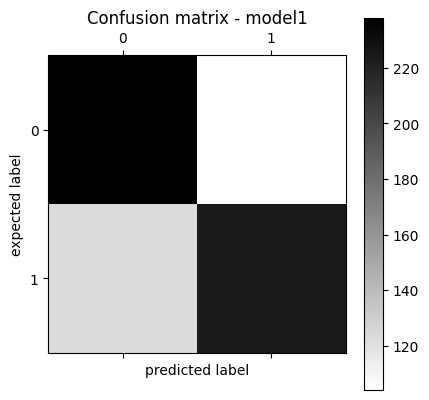

In [18]:
# Test model 1
test_preds = simple_cnn.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = simple_cnn.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

22/22 [==============================] - 6s 255ms/step
Correct predictions: 473.0
Total number of test examples: 689
Accuracy of model2:  0.6865021770682148
22/22 [==============================] - 5s 246ms/step


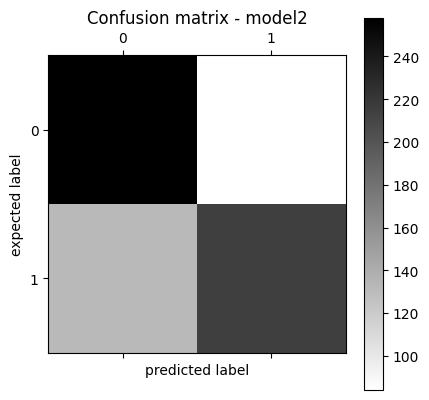

In [19]:
#Test model 2
test_preds2 = complex_cnn.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = complex_cnn.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

### Visualizations and metrics

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


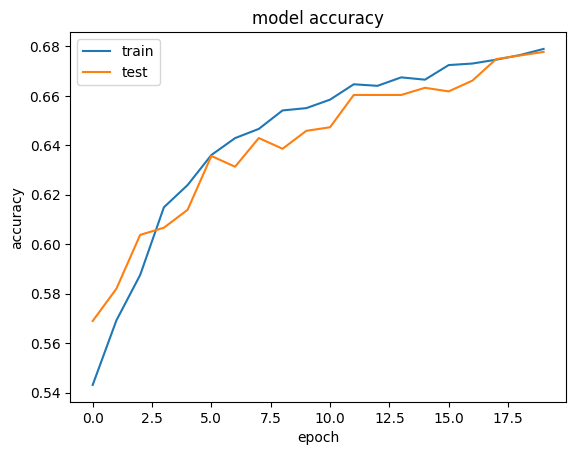

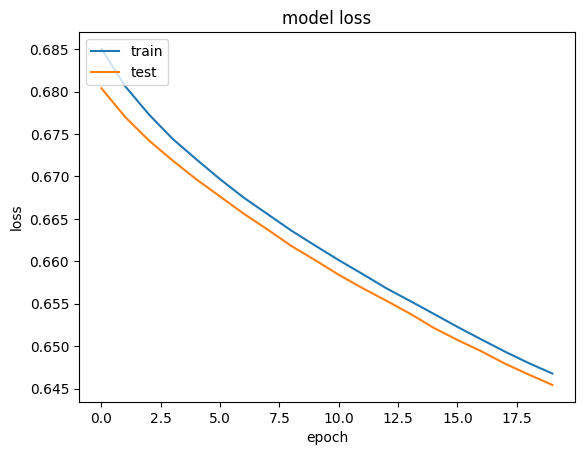

In [20]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

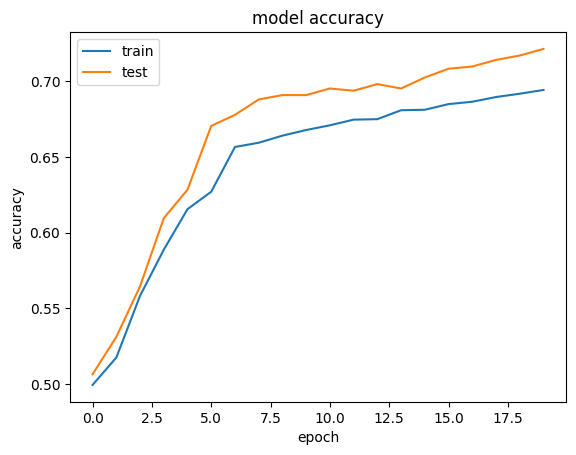

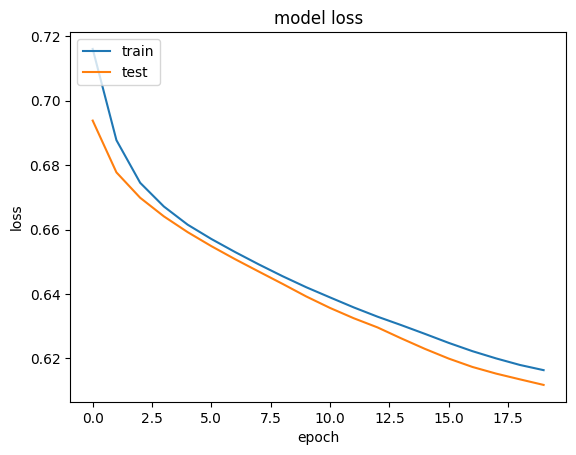

In [21]:
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Evaluate the model
y_pred = (complex_cnn.predict(x_test) > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, y_pred))

22/22 [==============================] - 6s 249ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       342
           1       0.72      0.62      0.67       347

   micro avg       0.69      0.69      0.69       689
   macro avg       0.69      0.69      0.69       689
weighted avg       0.69      0.69      0.69       689
 samples avg       0.69      0.69      0.69       689



In [23]:
# Evaluate the model
score = simple_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.646079957485199
Test accuracy: 0.670536994934082


In [24]:
# Evaluate the model
score = complex_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6198455095291138
Test accuracy: 0.6865021586418152


### Conclusions